<a href="https://colab.research.google.com/github/shpotes/modelacion-experimental/blob/master/notebooks/least-square/least_square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/shpotes/modelacion-experimental.git
%cd modelacion-experimental

fatal: destination path 'modelacion-experimental' already exists and is not an empty directory.
/content/modelacion-experimental


In [2]:
import logging
from functools import partial
logging.getLogger().setLevel(logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sy
from sympy.abc import t

from src import DiscreteModel
from src.methods import siso

In [3]:
na = 2
nb = 2
nk = 1

y_data = [0.0003, 3.5056, 2.8088, 2.8067, 2.7879, 2.7883, 2.7888, 2.7939]
N = len(y_data)
u_data = [1 for _ in range(N)]

In [4]:
def func_wrapper(data, idx):
    if idx < 0:
        return 0
    else:
        return data[idx]

In [5]:
y_func = partial(func_wrapper, y_data)
u_func = partial(func_wrapper, u_data)

In [6]:
arx = siso.ARX(na, nb, nk)
arx.get_transfer_function()

INFO:root:((b_1/q + b_2/q**2)/(1 + a_1/q + a_2/q**2), 1/(1 + a_1/q + a_2/q**2))
INFO:root:((b_1/z + b_2/z**2)/(1 + a_1/z + a_2/z**2), 1/(1 + a_1/z + a_2/z**2))


e(t)*z**2/(1*z**2 + a_1*z + a_2) + u(t)*(b_1*z + b_2)/(1*z**2 + a_1*z + a_2)

In [7]:
reg = arx.get_regresion_form()
reg

{'Φ': Matrix([
 [-y(t - 1)],
 [-y(t - 2)],
 [ u(t - 1)],
 [ u(t - 2)]]), 'θ': Matrix([
 [a_1],
 [a_2],
 [b_1],
 [b_2]])}

In [8]:
t = sy.symbols('t')

y_sym = sy.Function('y')
u_sym = sy.Function('u')

In [9]:
Q = sy.Matrix([
    reg['Φ'].T.replace(t, i) for i in range(1, N)
])

Q

Matrix([
[-y(0), -y(-1), u(0), u(-1)],
[-y(1),  -y(0), u(1),  u(0)],
[-y(2),  -y(1), u(2),  u(1)],
[-y(3),  -y(2), u(3),  u(2)],
[-y(4),  -y(3), u(4),  u(3)],
[-y(5),  -y(4), u(5),  u(4)],
[-y(6),  -y(5), u(6),  u(5)]])

In [10]:
Q_num = Q.replace(y_sym, y_func).replace(u_sym, u_func)
Q_num

Matrix([
[-0.0003,       0, 1, 0],
[-3.5056, -0.0003, 1, 1],
[-2.8088, -3.5056, 1, 1],
[-2.8067, -2.8088, 1, 1],
[-2.7879, -2.8067, 1, 1],
[-2.7883, -2.7879, 1, 1],
[-2.7888, -2.7883, 1, 1]])

In [11]:
Q_num = np.array(Q_num, dtype=np.float)

In [12]:
Y = sy.Matrix([
    y_sym(i) for i in range(1, N)
])
Y

Matrix([
[y(1)],
[y(2)],
[y(3)],
[y(4)],
[y(5)],
[y(6)],
[y(7)]])

In [13]:
Y_num = Y.replace(y_sym, y_func)
Y_num

Matrix([
[3.5056],
[2.8088],
[2.8067],
[2.7879],
[2.7883],
[2.7888],
[2.7939]])

In [14]:
Q_num

array([[-3.0000e-04,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       [-3.5056e+00, -3.0000e-04,  1.0000e+00,  1.0000e+00],
       [-2.8088e+00, -3.5056e+00,  1.0000e+00,  1.0000e+00],
       [-2.8067e+00, -2.8088e+00,  1.0000e+00,  1.0000e+00],
       [-2.7879e+00, -2.8067e+00,  1.0000e+00,  1.0000e+00],
       [-2.7883e+00, -2.7879e+00,  1.0000e+00,  1.0000e+00],
       [-2.7888e+00, -2.7883e+00,  1.0000e+00,  1.0000e+00]])

In [15]:
Y_num

Matrix([
[3.5056],
[2.8088],
[2.8067],
[2.7879],
[2.7883],
[2.7888],
[2.7939]])

In [16]:
sy.Matrix(np.linalg.inv(Q_num.T @ Q_num) @ Q_num.T)

Matrix([
[2.16899415095284e-13,     -1.27559979311465,    -5.02799844855991,    0.969100937611131,      1.6890219462874,     1.83377271091078,     1.81170264686521],
[4.97058991189014e-14,    0.0321450055243311,    -1.28256594402808,    0.173158096455911,    0.337180276172919,     0.37257751440616,    0.367505051468754],
[   0.999999999999999, -0.000382679937937502, -0.00150839953458171, 0.000290730281286011, 0.000506706583890848, 0.000550131813278232, 0.000543510794064561],
[  -0.999999999999245,     -3.47175250492671,    -17.6269457488505,     3.41484332699076,      5.9145178737586,      6.4230379141855,     6.34629913884208]])

In [17]:
theta = np.linalg.inv(Q_num.T @ Q_num) @ Q_num.T @ Y_num
theta = np.array(theta, dtype=np.float)

In [18]:
error = np.array(Q_num @ theta - Y_num, dtype=np.float)
error

array([[-4.44089210e-16],
       [-7.76413490e-05],
       [-4.36993423e-04],
       [ 3.66704492e-03],
       [ 1.19322252e-03],
       [ 3.46033081e-04],
       [-4.69166575e-03]])

In [19]:
# lambd
lambd = error.T @ error / (N - (na + nb))
lambd.flatten()[0]

9.29986406516148e-06

In [20]:
# Cov
sy.Matrix(lambd * np.linalg.inv(Q_num.T @ Q_num))

Matrix([
[0.000347302157143399,   7.8993792403348e-5,  1.04190647145037e-7,  0.00120555904489496],
[ 7.89937924033478e-5,  1.91907989793939e-5,  2.36981377214666e-8, 0.000277201641932899],
[ 1.04190647143965e-7,  2.36981377212205e-8,  9.29989532235562e-6,  -8.9381963516897e-6],
[ 0.00120555904489496, 0.000277201641932899, -8.93819635168597e-6,  0.00420294231826434]])

In [21]:
A = theta.flatten()[:na].tolist()
B = theta.flatten()[-nb:].tolist()

In [22]:
G_estim = DiscreteModel(B, [1, *A])
time, y_sim = G_estim.simulate(np.arange(N), u_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


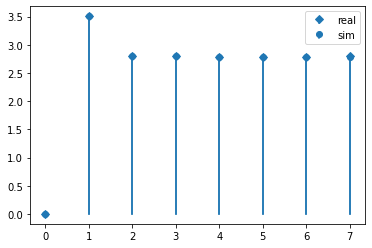

In [23]:
plt.stem(time, y_data, markerfmt='D', label='real', basefmt=' ')
plt.stem(time, y_sim, label='sim', basefmt=' ')
plt.legend()
plt.show()